## IMPORTING DATA

In [1]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 47.08 KiB | 1.57 MiB/s, done.


In [2]:
with open('superhero/superheroes.txt', 'r') as f:
  data = f.read()

## CREATING TOKENIZER

In [3]:
import tensorflow as tf

In [4]:
#Creating tokenizer. Tokenization basically means creating numeric representation of the characters in the dataset.
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', #Filtering out all the symbols not wanted to be used in the vocabulary
    split='\n',
)

In [5]:
tokenizer.fit_on_texts(data)

In [6]:
char_to_index = tokenizer.word_index #mapping i.e. dicts
index_to_char = dict((v,k) for k,v in char_to_index.items())

## CONVERTING BETWEEN NAMES AND SEQUENCES


In [7]:
names = data.splitlines()  # splitting into lines

In [8]:
tokenizer.texts_to_sequences(names[0]) #the 1 at the end is for the tab character

[[25], [16], [12], [20], [2], [1]]

In [9]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name] #return it as an array of the sequence

In [10]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [11]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i!= 0])

In [12]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

## CREATING AND PADDING SEQUENCES


In [13]:
sequences = []

for name in names:
  seq = name_to_seq(name)
  if len(seq) >= 2:
    sequences += [seq[:i] for i in range(2, len(seq)+1)]

In [14]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [15]:
max_len = max([len(j) for j in sequences]) #We need this as there will be a fixed length feeded to the model and not a variable, hence padding is required

In [16]:
padded_seq =  tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding ='pre',
    maxlen = max_len
)
padded_seq[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 16],
      dtype=int32)

In [17]:
padded_seq.shape

(88279, 33)

## CREATING TRAINING AND VALIDATION SETS

In [18]:
x, y = padded_seq[:, :-1], padded_seq[:, -1]
x.shape, y.shape

((88279, 32), (88279,))

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [20]:
#looking at vocab
num_chars = len(char_to_index.keys()) +1
print(num_chars)

29


## CREATING THE MODEL

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM
from tensorflow.keras.layers import Bidirectional, Dense

model = Sequential([
    Embedding (num_chars, 8, input_length = max_len-1), #8 is the length of the feature vector which is given as output
    Conv1D(64,5, strides =1, activation = 'tanh', padding = 'causal' ), #temporal (sequential) order of output is not violated by causal padding
    MaxPool1D(2),
    LSTM(32), #32 hidden layers
    Dense(num_chars, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16229 (63.39 KB)
Trainable params: 16229 (63.39 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

## TRAINING THE MODEL

In [22]:
x = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 50, verbose =2,
    callbacks= [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience =3)]#patience is the number of epochs during which the monitored metric (e.g., validation loss or validation accuracy) is allowed to not improve before training is halted.
)

Epoch 1/50
2070/2070 - 26s - loss: 2.7556 - accuracy: 0.1895 - val_loss: 2.6026 - val_accuracy: 0.2247 - 26s/epoch - 13ms/step
Epoch 2/50
2070/2070 - 12s - loss: 2.5468 - accuracy: 0.2341 - val_loss: 2.5145 - val_accuracy: 0.2401 - 12s/epoch - 6ms/step
Epoch 3/50
2070/2070 - 11s - loss: 2.4717 - accuracy: 0.2566 - val_loss: 2.4583 - val_accuracy: 0.2643 - 11s/epoch - 5ms/step
Epoch 4/50
2070/2070 - 12s - loss: 2.4179 - accuracy: 0.2682 - val_loss: 2.4151 - val_accuracy: 0.2671 - 12s/epoch - 6ms/step
Epoch 5/50
2070/2070 - 11s - loss: 2.3770 - accuracy: 0.2760 - val_loss: 2.3861 - val_accuracy: 0.2774 - 11s/epoch - 5ms/step
Epoch 6/50
2070/2070 - 12s - loss: 2.3444 - accuracy: 0.2857 - val_loss: 2.3681 - val_accuracy: 0.2812 - 12s/epoch - 6ms/step
Epoch 7/50
2070/2070 - 11s - loss: 2.3175 - accuracy: 0.2967 - val_loss: 2.3498 - val_accuracy: 0.2883 - 11s/epoch - 5ms/step
Epoch 8/50
2070/2070 - 11s - loss: 2.2937 - accuracy: 0.3045 - val_loss: 2.3296 - val_accuracy: 0.2937 - 11s/epoch - 

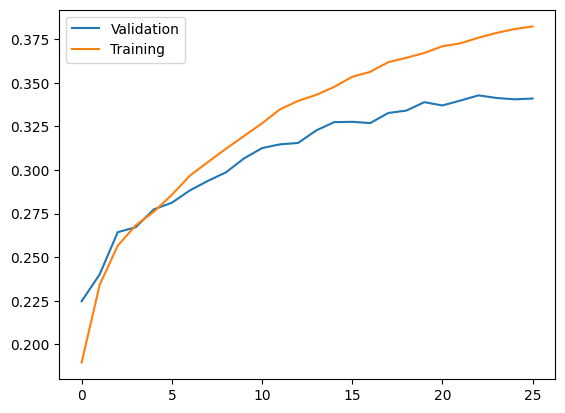

In [23]:
from matplotlib import pyplot as plt
epochs_ran = len(x.history['loss'])
plt.plot(range(0, epochs_ran), x.history['val_accuracy'], label = "Validation")
plt.plot(range(0, epochs_ran), x.history['accuracy'], label = "Training")
plt.legend()
plt.show()

## GENERATING NAMES


In [24]:
def gen_names(seed):
  for i in range(0, 40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding = 'pre',
                                                           maxlen = max_len-1,
                                                           truncating = 'pre') #to see the early numbers of the seed
    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char=='\t':
      break
  print (seed)

In [28]:
gen_names('Bro')
print(max_len)

1/1 [==============================] - 0s 29ms/step
Brood	
33


In [27]:
import pickle
# Save the model and tokenizer
model.save("superhero_model.h5")

tokenizer_path = '/content/tokenizer.pkl'
with open(tokenizer_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
